# Deep dive into results

Analysing what the true positive rate for the predictions is.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import plotly.express as px

from matplotlib_venn import venn3_unweighted
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

# Load datasets

In [3]:
ecbl_df = pd.read_csv("../data/predictions/euos_ecbl_predictions.csv")
ecbl_df.head(2)

,eos,smiles,Pseudomonas_aeruginosa_activity,Pseudomonas_aeruginosa_value,Candida_auris_activity,Candida_auris_value,Enterococcus_faecalis_activity,Enterococcus_faecalis_value,Escherichia_coli_activity,Escherichia_coli_value,Aspergillus_fumigatus_activity,Aspergillus_fumigatus_value,Candida_albicans_activity,Candida_albicans_value,Staphylococcus_aureus_activity,Staphylococcus_aureus_value,mhfp6,prediction,probability
0,EOS82284,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F,inactive,-4.11,inconclusive,63.4,inactive,-20.8,inactive,-4.91,inactive,-31.7,inactive,1.75,inactive,-0.55,[297691353 76444608 30417937 ... 84759602 ...,fungi,0.955887
1,EOS11458,COc1ccc(C(=O)Nc2ccc(C)cc2)cc1OC,inactive,-6.49,inactive,27.8,inactive,-0.5,inactive,-4.83,inactive,-25.6,inactive,-6.30,inactive,7.90,[355394601 44409534 127404489 ... 67864610 ...,fungi,0.955829


In [4]:
bioactive_df = pd.read_csv("../data/predictions/euos_biactive_predictions.csv")
bioactive_df.head(2)

,eos,smiles,Pseudomonas_aeruginosa_activity,Pseudomonas_aeruginosa_value,Candida_auris_activity,Candida_auris_value,Enterococcus_faecalis_activity,Enterococcus_faecalis_value,Escherichia_coli_activity,Escherichia_coli_value,Aspergillus_fumigatus_activity,Aspergillus_fumigatus_value,Candida_albicans_activity,Candida_albicans_value,Staphylococcus_aureus_activity,Staphylococcus_aureus_value,mhfp6,prediction,probability
0,EOS102228,Cl.Cl.NCCCCCCCCN,inactive,-6.89,inactive,12.233333,inactive,-4.7,inactive,-12.17,inactive,-17.0,inactive,-16.95,inactive,10.95,[461248215 33988699 706189559 ... 231087554 ...,acid-fast,1.000000
1,EOS100708,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12.Cl,inactive,-0.17,active,71.800000,inactive,-22.3,inactive,-5.59,active,97.2,inconclusive,52.90,inactive,12.00,[123358859 33988699 63689098 ... 21856680 1...,fungi,0.999477


In [5]:
def get_prediction_distribution(df):
    pred_dict = {}

    for eos_id, pred in tqdm(df[["eos", "prediction"]].values):
        if pred not in pred_dict:
            pred_dict[pred] = set()
        pred_dict[pred].add(eos_id)

    fig = px.pie(
        values=[len(v) for v in pred_dict.values()],
        names=[k for k in pred_dict.keys()],
    )
    fig.show()

In [6]:
get_prediction_distribution(ecbl_df)

100%|██████████| 96092/96092 [00:00<00:00, 508455.00it/s]


In [7]:
get_prediction_distribution(bioactive_df)

  0%|          | 0/4927 [00:00<?, ?it/s]

100%|██████████| 4927/4927 [00:00<00:00, 398667.64it/s]


In [8]:
def get_activity_distribution(df, library_name, title):
    act_dict = []

    orgs = {
        "Staphylococcus_aureus": "gram-positive",
        "Pseudomonas_aeruginosa": "gram-negative",
        "Candida_auris": "fungi",
        "Enterococcus_faecalis": "gram-positive",
        "Aspergillus_fumigatus": "fungi",
        "Candida_albicans": "fungi",
        "Escherichia_coli": "gram-negative",
    }

    val_cols = [f"{col}_value" for col in orgs.keys()]

    for val, org in zip(val_cols, orgs.keys()):
        tmp = df[["eos", val]].dropna()
        tmp["activity"] = tmp[val].apply(lambda x: "Active" if x >= 50 else "Inactive")
        tmp_act_dict = tmp["activity"].value_counts().to_dict()
        tmp_act_dict["organism"] = " ".join(org.split("_"))
        tmp_act_dict["organism_type"] = orgs[org]
        act_dict.append(tmp_act_dict)

    act_df = pd.DataFrame(act_dict)
    act_df = act_df.set_index("organism")

    total = act_df.select_dtypes(include="number").sum(axis=1)
    act_df["total"] = total
    act_df["active_percentage"] = (act_df["Active"] / act_df["total"]) * 100
    act_df["active_percentage"] = act_df["active_percentage"].round(2)
    act_df.sort_values(by="active_percentage", ascending=False, inplace=True)

    plt.figure(figsize=(20, 10))
    sns.barplot(
        data=act_df,
        x=act_df.index,
        y="active_percentage",
        color="#ffb266",
        label="Active percentage",
        estimator=sum,
    )

    # add counts on the top of the bars
    for i in range(len(act_df)):
        plt.text(
            i,
            act_df["active_percentage"][i],
            f"{act_df['active_percentage'][i]} %",
            ha="center",
            va="bottom",
            fontsize=16,
        )
    plt.xlabel("Pathogen", fontsize=18)
    plt.ylabel("Active percentage", fontsize=18)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f"Activity distribution of {library_name} compounds", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"../figures/{title}.png", dpi=400)
    plt.show()
    return act_df

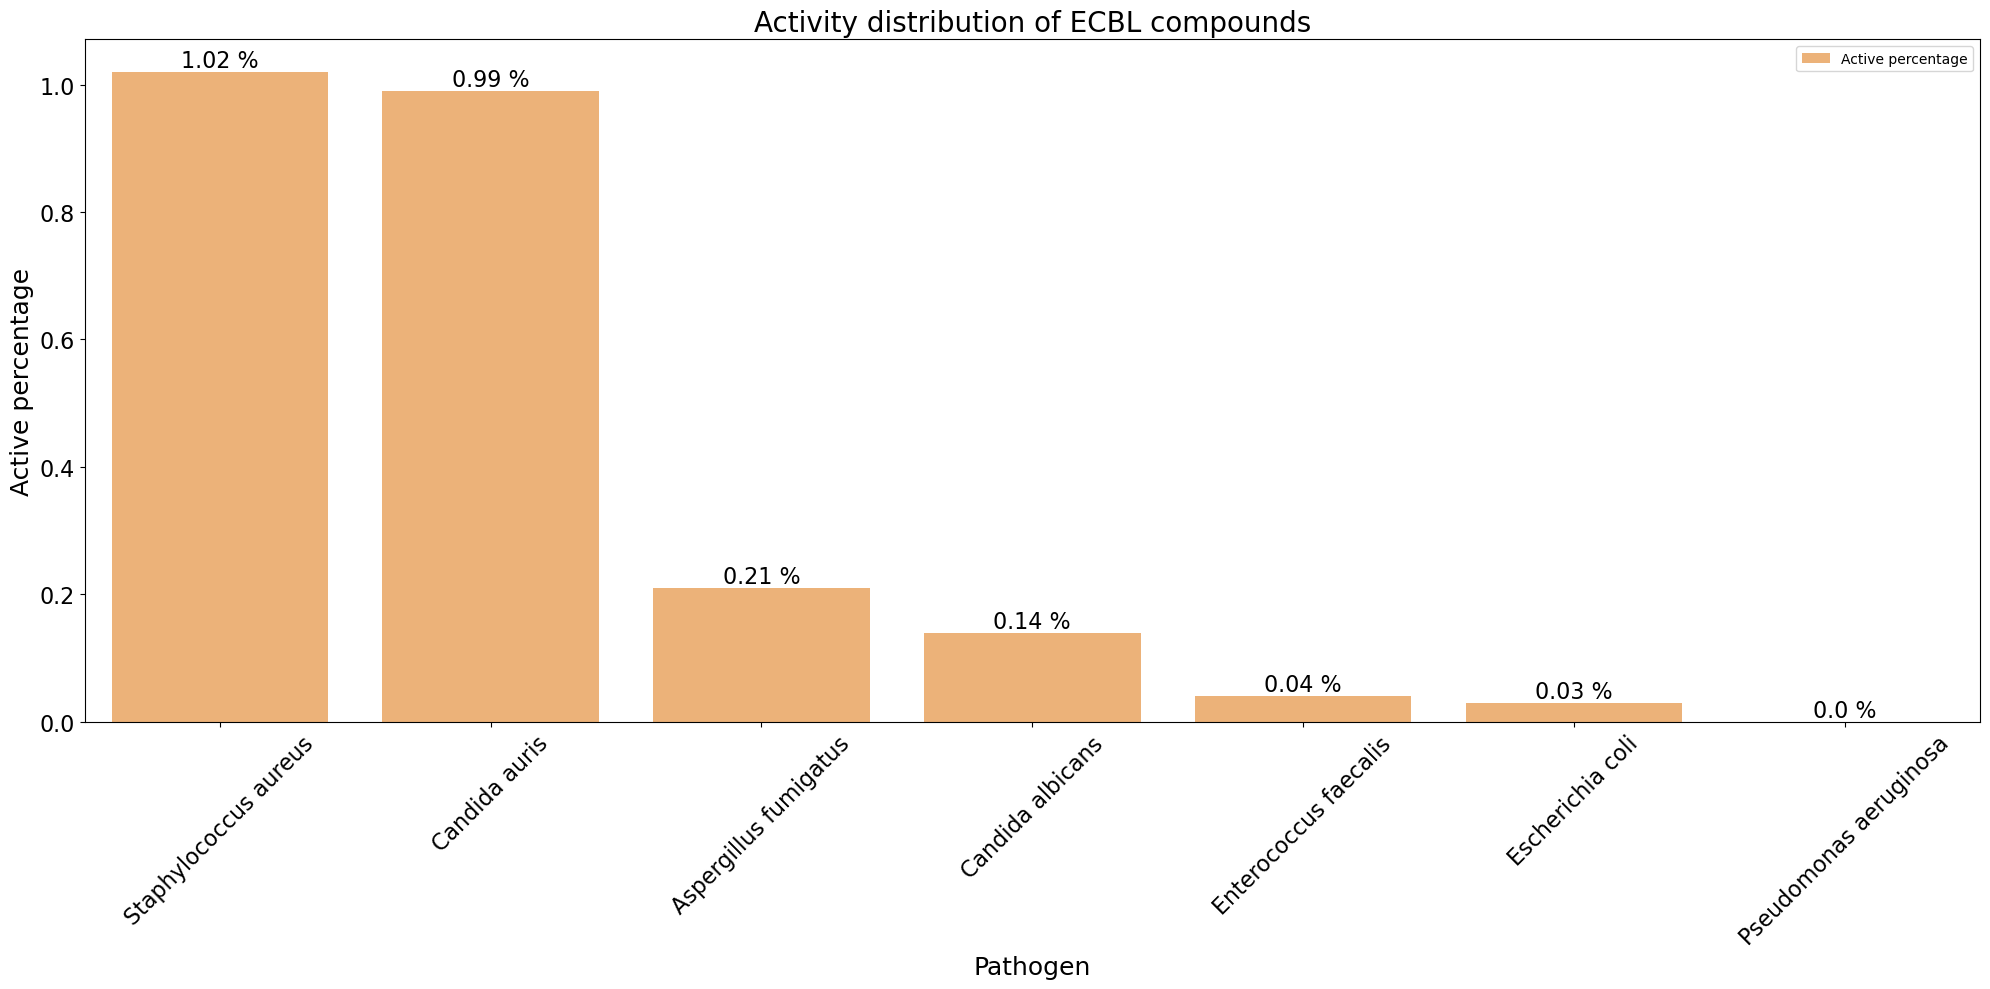

In [9]:
df_1 = get_activity_distribution(ecbl_df, title="figure_8", library_name="ECBL")

In [10]:
# normalize the values row-wise
df_1["sum"] = df_1.select_dtypes(include="number").sum(axis=1)
df_1["Inactive"] = df_1["Inactive"].div(df_1["sum"], axis=0) * 100
df_1["Active"] = df_1["Active"].div(df_1["sum"], axis=0) * 100
df_1 = df_1.drop(columns=["sum"])
df_1.sort_values(by="organism_type")

,Inactive,Active,organism_type,total,active_percentage
organism,,,,,
Candida auris,49.507047,0.492696,fungi,96002,0.99
Aspergillus fumigatus,49.896878,0.103067,fungi,96054,0.21
Candida albicans,49.931724,0.068239,fungi,95986,0.14
Escherichia coli,49.986462,0.013530,gram-negative,96082,0.03
Pseudomonas aeruginosa,49.999480,0.000520,gram-negative,96062,0.00
Staphylococcus aureus,49.487416,0.512318,gram-positive,95936,1.02
Enterococcus faecalis,49.982271,0.017718,gram-positive,95946,0.04


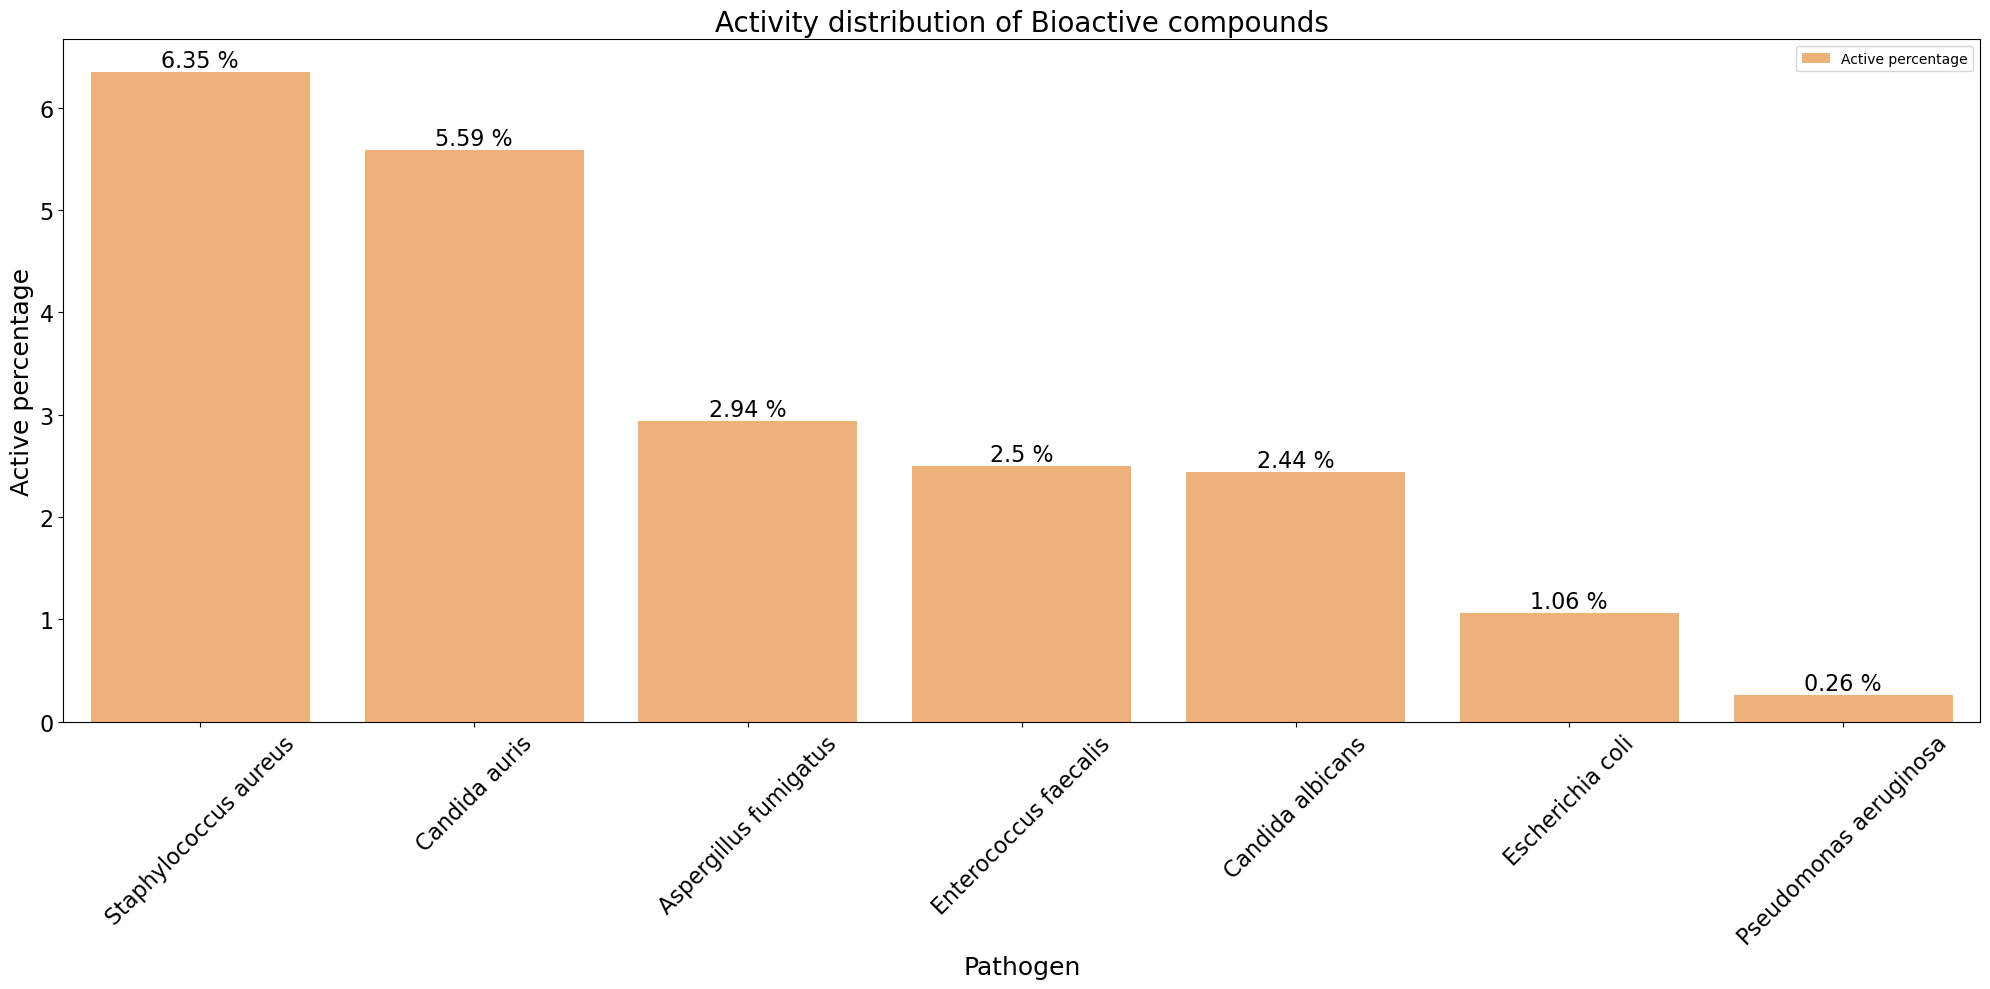

In [11]:
df_2 = get_activity_distribution(
    bioactive_df, title="figure_9", library_name="Bioactive"
)

In [12]:
# normalize the values row-wise
df_2["sum"] = df_2.select_dtypes(include="number").sum(axis=1)
df_2["Inactive"] = df_2["Inactive"].div(df_2["sum"], axis=0) * 100
df_2["Active"] = df_2["Active"].div(df_2["sum"], axis=0) * 100
df_2 = df_2.drop(columns=["sum"])
df_2.sort_values(by="organism_type")

,Inactive,Active,organism_type,total,active_percentage
organism,,,,,
Candida auris,47.179629,2.791994,fungi,4922,5.59
Aspergillus fumigatus,48.513137,1.471941,fungi,4924,2.94
Candida albicans,48.769145,1.218467,fungi,4923,2.44
Escherichia coli,49.466541,0.528076,gram-negative,4923,1.06
Pseudomonas aeruginosa,49.866758,0.131923,gram-negative,4927,0.26
Staphylococcus aureus,46.793471,3.174330,gram-positive,4927,6.35
Enterococcus faecalis,48.738130,1.249175,gram-positive,4922,2.50


# Evaluating the prediction rate

In [13]:
def get_prediction_accuracy_all(df):
    orgs = {
        "Staphylococcus_aureus": "gram-positive",
        "Pseudomonas_aeruginosa": "gram-negative",
        "Candida_auris": "fungi",
        "Enterococcus_faecalis": "gram-positive",
        "Aspergillus_fumigatus": "fungi",
        "Candida_albicans": "fungi",
        "Escherichia_coli": "gram-negative",
    }

    val_cols = [f"{col}_value" for col in orgs.keys()]

    t = []

    for val_col_name, org in zip(val_cols, orgs):
        ecbl_subset_custom = df[[val_col_name, "prediction"]]

        # Custom thresholding for bioactive
        ecbl_subset_custom["exp_vals"] = ecbl_subset_custom[val_col_name].apply(
            lambda x: "Active" if x >= 50 else "Inactive"
        )

        # Model binary prediction
        ecbl_subset_custom["model_pred"] = ecbl_subset_custom["prediction"].apply(
            lambda x: "Active" if x == orgs[org] else "Inactive"
        )

        # Exp vals
        exp_actives = ecbl_subset_custom[
            ecbl_subset_custom["exp_vals"] == "Active"
        ].shape[0]

        # Calculate accuracy
        ecbl_subset_custom["correct"] = (
            ecbl_subset_custom["exp_vals"] == ecbl_subset_custom["model_pred"]
        )
        true_actives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        true_inactives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        false_actives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        false_inactives = ecbl_subset_custom[
            (ecbl_subset_custom["exp_vals"] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        hitrate_exp = (exp_actives / ecbl_subset_custom.shape[0]) * 100
        hitrate_tool = (true_actives / (true_actives + false_actives)) * 100
        t.append(
            {
                "org": org,
                "accuracy": (
                    (true_actives + true_inactives) / ecbl_subset_custom.shape[0]
                )
                * 100,
                "true_actives": true_actives,
                "true_inactives": true_inactives,
                "false_actives": false_actives,
                "false_inactives": false_inactives,
                "tp rate": (true_actives / (true_actives + false_inactives)) * 100,
                "exp_hitrate": hitrate_exp,
                "tool_hitrate": hitrate_tool,
                "enrichment": hitrate_tool / hitrate_exp
            }
        )

    kk = pd.DataFrame(t)
    mean_diff = kk["tp rate"].mean() - kk["exp_hitrate"].mean()
    print(f"Mean difference: {mean_diff}")
    return kk

In [14]:
ecbl_df2 = get_prediction_accuracy_all(ecbl_df)
ecbl_df2

Mean difference: 5.68552387060958


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate,tool_hitrate,enrichment
0,Staphylococcus_aureus,95.171294,41,91411,3698,942,4.170905,1.022978,1.096550,1.071919
1,Pseudomonas_aeruginosa,99.009283,0,95140,951,1,0.000000,0.001041,0.000000,0.000000
2,Candida_auris,97.520085,19,93690,1456,927,2.008457,0.984473,1.288136,1.308452
3,Enterococcus_faecalis,96.086043,6,92325,3733,28,17.647059,0.035383,0.160471,4.535280
4,Aspergillus_fumigatus,98.271448,6,94425,1469,192,3.030303,0.206053,0.406780,1.974155
5,Candida_albicans,98.339092,5,94491,1470,126,3.816794,0.136328,0.338983,2.486531
6,Escherichia_coli,98.989510,3,95118,948,23,11.538462,0.027057,0.315457,11.658821


In [15]:
bioactive_df2 = get_prediction_accuracy_all(bioactive_df)
bioactive_df2

Mean difference: 24.891001350925126


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate,tool_hitrate,enrichment
0,Staphylococcus_aureus,85.934646,80,4154,460,233,25.559105,6.352750,14.814815,2.332032
1,Pseudomonas_aeruginosa,97.848589,6,4815,99,7,46.153846,0.263852,5.714286,21.657143
2,Candida_auris,94.134362,42,4596,56,233,15.272727,5.581490,42.857143,7.678442
3,Enterococcus_faecalis,88.410798,46,4310,494,77,37.398374,2.496448,8.518519,3.412255
4,Aspergillus_fumigatus,96.529328,36,4720,62,109,24.827586,2.942967,36.734694,12.482196
5,Candida_albicans,96.793180,30,4739,68,90,25.000000,2.435559,30.612245,12.568878
6,Escherichia_coli,97.259996,11,4781,94,41,21.153846,1.055409,10.476190,9.926190


In [16]:
def statistics_hitrates(df):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

    # Extract unpaired data
    experimental = df["exp_hitrate"]
    predicted = df["tool_hitrate"]

    test_result = ttest_ind(experimental, predicted, equal_var=False)
    test_name = "Independent t-test (unequal variances)"

    # Extract p-value
    p_value = test_result.pvalue

    # Print statistical information
    print(f"{test_name}: {test_result}")
    print(f"Experimental Mean ± Std: {np.mean(experimental):.2f} ± {np.std(experimental):.2f}")
    print(f"Predicted Mean ± Std: {np.mean(predicted):.2f} ± {np.std(predicted):.2f}")
    print(f"p-value: {p_value:.5f}")

    # Determine significance level
    if p_value < 0.001:
        sig_level = "***"
    elif p_value < 0.01:
        sig_level = "**"
    elif p_value < 0.05:
        sig_level = "*"
    else:
        sig_level = "n.s."  # Not significant

    # Combine data for plotting
    data = pd.DataFrame({
        "Hit Rates": np.concatenate([experimental, predicted]),
        "Group": ["Experimental"] * len(experimental) + ["Predicted"] * len(predicted)
    })

    # Plot boxplot
    sns.boxplot(x="Group", y="Hit Rates", data=data)
    plt.title("Comparison of Experimental vs Predicted Hit Rates")

    # Add significance bracket
    y_max = max(data["Hit Rates"])  # Maximum value for y-axis
    y_bracket = y_max + (0.05 * y_max)  # Slightly above the max for the bracket
    plt.plot([0, 1], [y_bracket, y_bracket], color="black", lw=1.0)  # Horizontal line for the bracket
    plt.text(0.5, y_bracket + (0.02 * y_max), sig_level, ha="center", va="bottom", fontsize=12, color="black")  # Significance level

    # Adjust plot
    plt.ylabel("Hit Rates (%)")
    plt.ylim(0, y_bracket + (0.1 * y_max))  # Expand y-axis to fit the bracket
    plt.show()

Results for comparing experimental and predicted hit rates of ECBL data
Independent t-test (unequal variances): TtestResult(statistic=np.float64(-0.6777537237332804), pvalue=np.float64(0.5108320767449763), df=np.float64(11.9551530360067))
Experimental Mean ± Std: 0.34 ± 0.42
Predicted Mean ± Std: 0.52 ± 0.45
p-value: 0.51083


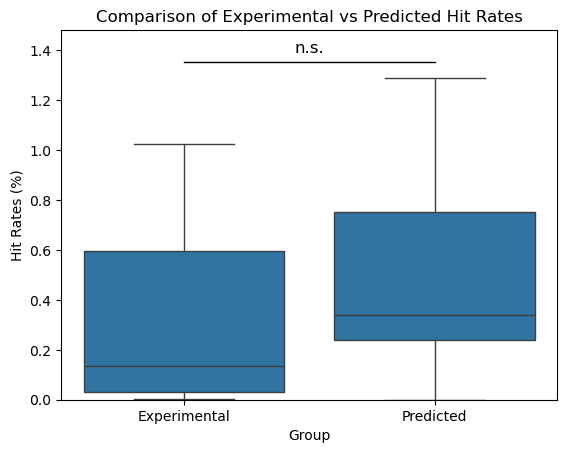


Results for comparing experimental and predicted hit rates of Bioactive data
Independent t-test (unequal variances): TtestResult(statistic=np.float64(-3.1993786326159825), pvalue=np.float64(0.01754469372417545), df=np.float64(6.263288001365331))
Experimental Mean ± Std: 3.02 ± 2.06
Predicted Mean ± Std: 21.39 ± 13.91
p-value: 0.01754


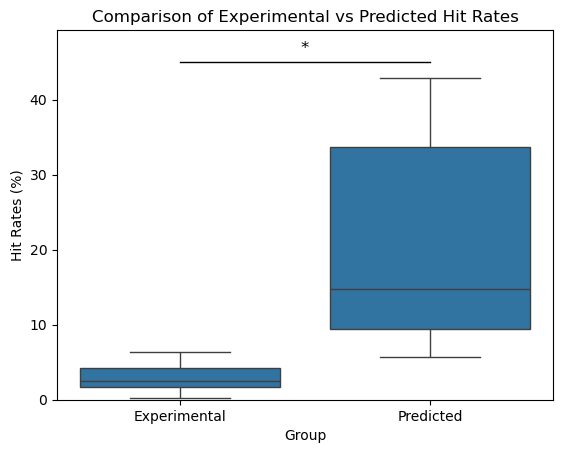

In [17]:
print("Results for comparing experimental and predicted hit rates of ECBL data")
statistics_hitrates(ecbl_df2)
print("")
print("Results for comparing experimental and predicted hit rates of Bioactive data")
statistics_hitrates(bioactive_df2)

In [22]:
def statistics_testsize(df):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

    # Extract unpaired data
    experimental = df["true_actives"] + df["true_inactives"] + df["false_actives"] + df["false_inactives"]
    predicted = df["true_actives"] + df["false_actives"]

    test_result = ttest_ind(experimental, predicted, equal_var=False)
    test_name = "Independent t-test (unequal variances)"

    # Extract p-value
    p_value = test_result.pvalue

    # Print statistical information
    print(f"{test_name}: {test_result}")
    print(f"Experimental Mean ± Std: {np.mean(experimental):.2f} ± {np.std(experimental):.2f}")
    print(f"Predicted Mean ± Std: {np.mean(predicted):.2f} ± {np.std(predicted):.2f}")
    print(f"p-value: {p_value:.5f}")

    # Determine significance level
    if p_value < 0.001:
        sig_level = "***"
    elif p_value < 0.01:
        sig_level = "**"
    elif p_value < 0.05:
        sig_level = "*"
    else:
        sig_level = "n.s."  # Not significant

    # Combine data for plotting
    data = pd.DataFrame({
        "Hit Rates": np.concatenate([experimental, predicted]),
        "Group": ["Experimental"] * len(experimental) + ["Predicted"] * len(predicted)
    })

    # Plot boxplot
    sns.boxplot(x="Group", y="Hit Rates", data=data)
    plt.title("Comparison of Experimental vs Predicted Library Size")

    # Add significance bracket
    y_max = max(data["Hit Rates"])  # Maximum value for y-axis
    y_bracket = y_max + (0.05 * y_max)  # Slightly above the max for the bracket
    plt.plot([0, 1], [y_bracket, y_bracket], color="black", lw=1.0)  # Horizontal line for the bracket
    plt.text(0.5, y_bracket + (0.02 * y_max), sig_level, ha="center", va="bottom", fontsize=12, color="black")  # Significance level

    # Adjust plot
    plt.ylabel("Library size")
    plt.ylim(0, y_bracket + (0.1 * y_max))  # Expand y-axis to fit the bracket
    plt.show()

Results for comparing experimental and predicted test library sizes of Bioactive data
Independent t-test (unequal variances): TtestResult(statistic=np.float64(58.0268318068645), pvalue=np.float64(1.7599524127454065e-09), df=np.float64(6.0))
Experimental Mean ± Std: 4927.00 ± 0.00
Predicted Mean ± Std: 226.29 ± 198.43
p-value: 0.00000


c:\Users\Leonie.Berlin\AppData\Local\miniconda3\envs\kg_dashboard\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



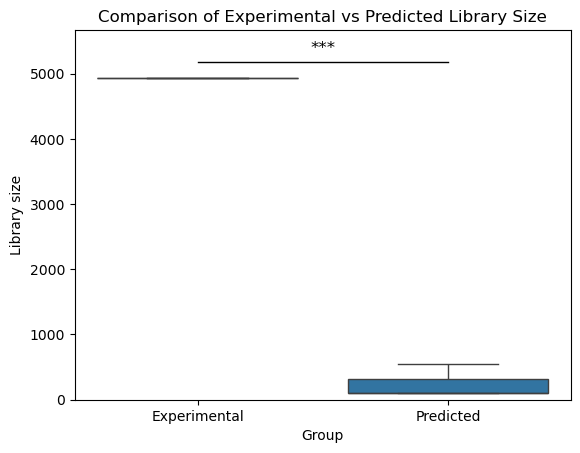


Results for comparing experimental and predicted test library sizes of ECBL data
Independent t-test (unequal variances): TtestResult(statistic=np.float64(202.53057948839836), pvalue=np.float64(9.776724918684693e-13), df=np.float64(6.0))
Experimental Mean ± Std: 96092.00 ± 0.00
Predicted Mean ± Std: 1972.14 ± 1138.33
p-value: 0.00000


c:\Users\Leonie.Berlin\AppData\Local\miniconda3\envs\kg_dashboard\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



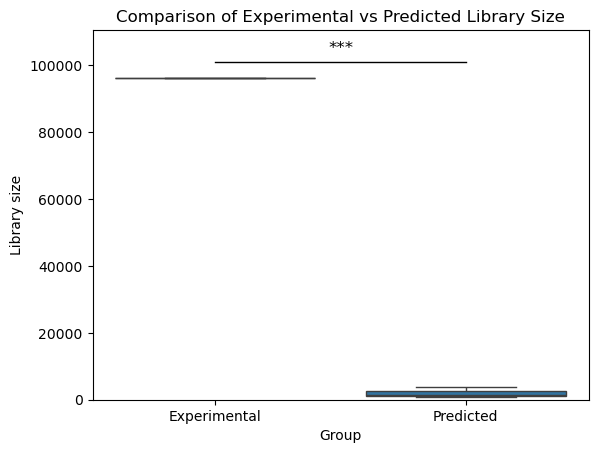

In [23]:
print("Results for comparing experimental and predicted test library sizes of Bioactive data")
statistics_testsize(bioactive_df2)
print("")
print("Results for comparing experimental and predicted test library sizes of ECBL data")
statistics_testsize(ecbl_df2)

In [24]:
def get_prediction_pathogen_class_wise(df):
    orgs = {
        "gram-positive": ["Staphylococcus_aureus", "Enterococcus_faecalis"],
        "gram-negative": ["Pseudomonas_aeruginosa", "Escherichia_coli"],
        "fungi": ["Candida_auris", "Aspergillus_fumigatus", "Candida_albicans"],
    }

    t = []

    for pathogen_class, col_names in orgs.items():
        val_cols = [f"{col}_value" for col in col_names]
        val_cols.append("prediction")
        ecbl_subset_custom = df[val_cols]

        exp_vals = {}

        for val_col in val_cols[:-1]:
            exp_vals[val_col] = ecbl_subset_custom[val_col].apply(
                lambda x: "Active" if x >= 50 else "Inactive"
            )  # Custom thresholding for bioactive

        exp_values = list(zip(*[v for v in exp_vals.values()]))
        final_vals = []

        for vals in exp_values:
            if "Active" in vals:
                final_vals.append("Active")
            else:
                final_vals.append("Inactive")

        ecbl_subset_custom[pathogen_class] = final_vals

        # Model binary prediction
        ecbl_subset_custom["model_pred"] = ecbl_subset_custom["prediction"].apply(
            lambda x: "Active" if x == pathogen_class else "Inactive"
        )

        # Exp vals
        exp_actives = ecbl_subset_custom[
            ecbl_subset_custom[pathogen_class] == "Active"
        ].shape[0]

        # Calculate accuracy
        ecbl_subset_custom["correct"] = (
            ecbl_subset_custom[pathogen_class] == ecbl_subset_custom["model_pred"]
        )
        true_actives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        true_inactives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        false_actives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Inactive")
            & (ecbl_subset_custom["model_pred"] == "Active")
        ].shape[0]
        false_inactives = ecbl_subset_custom[
            (ecbl_subset_custom[pathogen_class] == "Active")
            & (ecbl_subset_custom["model_pred"] == "Inactive")
        ].shape[0]
        t.append(
            {
                "class": pathogen_class,
                "accuracy": (
                    (true_actives + true_inactives) / ecbl_subset_custom.shape[0]
                )
                * 100,
                "true_actives": true_actives,
                "true_inactives": true_inactives,
                "false_actives": false_actives,
                "false_inactives": false_inactives,
                "tp rate": (true_actives / (true_actives + false_inactives)) * 100,
                "exp_hitrate": (exp_actives / ecbl_subset_custom.shape[0]) * 100,
            }
        )

    return pd.DataFrame(t)

In [25]:
get_prediction_pathogen_class_wise(ecbl_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,95.167131,41,91407,3698,946,4.154002,1.027141
1,gram-negative,98.988469,3,95117,948,24,11.111111,0.028098
2,fungi,97.380635,21,93554,1454,1063,1.937269,1.128086


In [26]:
get_prediction_pathogen_class_wise(bioactive_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,85.873757,81,4150,459,237,25.471698,6.454232
1,gram-negative,97.259996,11,4781,94,41,21.153846,1.055409
2,fungi,93.403694,45,4557,53,272,14.195584,6.433935


# Similarity with training data

In [28]:
training_df = pd.read_csv("../data/splits/combined/mhfp6_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,cmp_id,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,OQZSOIHVULQZHS-CWGWECIMSA-N,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,ZGNROOOFYPKLJH-UHFFFAOYSA-N,inactive


In [20]:
bioactive_inchikeys = []

for smile in tqdm(bioactive_df["smiles"].values):
    mol = Chem.MolFromSmiles(smile)
    inchikey = Chem.inchi.MolToInchiKey(mol)
    bioactive_inchikeys.append(inchikey)

bioactive_df["inchikey"] = bioactive_inchikeys

100%|██████████| 4927/4927 [00:01<00:00, 3694.91it/s]


In [21]:
ecbl_inchikeys = []

for smile in tqdm(ecbl_df["smiles"].values):
    mol = Chem.MolFromSmiles(smile)
    inchikey = Chem.inchi.MolToInchiKey(mol)
    ecbl_inchikeys.append(inchikey)

ecbl_df["inchikey"] = ecbl_inchikeys

100%|██████████| 96092/96092 [00:23<00:00, 4102.01it/s]


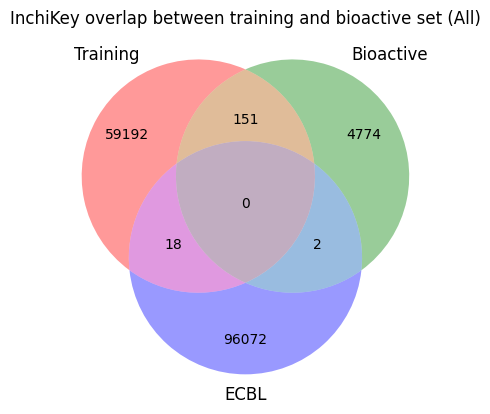

In [22]:
bioactive_inchikeys = set(bioactive_df["inchikey"].values)
training_inchikeys = set(training_df["cmp_id"].values)
ecbl_inchikeys = set(ecbl_df["inchikey"].values)

venn3_unweighted(
    [training_inchikeys, bioactive_inchikeys, ecbl_inchikeys],
    set_labels=("Training", "Bioactive", "ECBL"),
)
plt.title(f"InchiKey overlap between training and bioactive set (All)")
plt.show()

In [23]:
def plot_cmpd_overlap():
    k = []
    for strain_name in [
        "Staphylococcus_aureus",
        "Pseudomonas_aeruginosa",
        "Candida_auris",
        "Enterococcus_faecalis",
        "Aspergillus_fumigatus",
        "Candida_albicans",
        "Escherichia_coli",
    ]:
        col_name = f"{strain_name}_value"
        bioactive_inchikeys = []

        for val, inchikey in bioactive_df[[col_name, "inchikey"]].values:
            if val >= 50:
                bioactive_inchikeys.append(inchikey)

        bioactive_inchikeys = set(bioactive_inchikeys)
        training_inchikeys = set(training_df["cmp_id"].values)

        inchikeys_in_training = len(
            bioactive_inchikeys.intersection(training_inchikeys)
        )
        inchikeys_in_bioactive = len(bioactive_inchikeys.difference(training_inchikeys))

        k.append(
            {
                "strain": strain_name,
                "Found in training": inchikeys_in_training,
                "Not found in training": inchikeys_in_bioactive,
            }
        )

    df = pd.DataFrame(k)

    fig = px.bar(
        df,
        x="strain",
        y=["Found in training", "Not found in training"],
        barmode="group",
        title="InchiKey overlap between training and bioactive set (All)",
    )

    # show %age overlap on top of bars
    for i in range(len(df)):
        fig.add_annotation(
            x=df["strain"][i],
            y=df["Found in training"][i],
            text=f"{(df['Found in training'][i] / (df['Found in training'][i] + df['Not found in training'][i])) * 100:.2f}%",
            showarrow=True,
        )

    fig.show()

In [24]:
plot_cmpd_overlap()

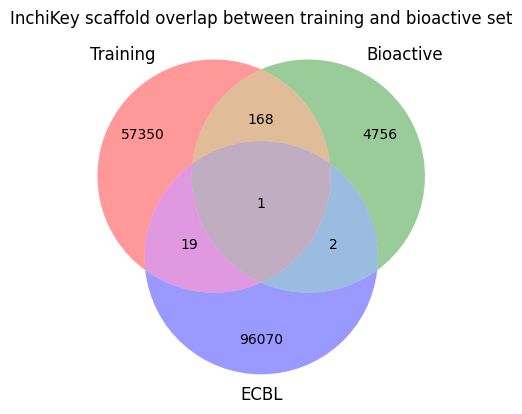

In [25]:
bioactive_scaffolds = set([i.split("-")[0] for i in bioactive_inchikeys])
training_scaffolds = set([i.split("-")[0] for i in training_inchikeys])
ecbl_scaffolds = set([i.split("-")[0] for i in ecbl_inchikeys])

venn3_unweighted(
    [training_scaffolds, bioactive_scaffolds, ecbl_scaffolds],
    set_labels=("Training", "Bioactive", "ECBL"),
)
plt.title("InchiKey scaffold overlap between training and bioactive set")
plt.show()

# Prediction probabilities after removal of training set compounds

In [26]:
bioactive_overlapped_compounds = bioactive_inchikeys.intersection(training_inchikeys)
ecbl_overlapped_compounds = ecbl_inchikeys.intersection(training_inchikeys)

In [27]:
len(bioactive_overlapped_compounds), len(ecbl_overlapped_compounds)

(151, 18)

In [28]:
ecbl_non_train_df = ecbl_df[~ecbl_df["inchikey"].isin(ecbl_overlapped_compounds)]
bioactive_non_train_df = bioactive_df[
    ~bioactive_df["inchikey"].isin(bioactive_overlapped_compounds)
]

len(ecbl_df), len(ecbl_non_train_df), len(bioactive_non_train_df), len(bioactive_df)

(96092, 96074, 4776, 4927)

In [29]:
get_prediction_accuracy_all(ecbl_non_train_df)

Mean difference: 4.99451083274408


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,95.175594,40,91399,3696,939,4.085802,1.019006
1,Pseudomonas_aeruginosa,99.014301,0,95127,946,1,0.000000,0.001041
2,Candida_auris,97.525865,16,93681,1453,924,1.702128,0.978412
3,Enterococcus_faecalis,96.087391,5,92310,3731,28,15.151515,0.034349
4,Aspergillus_fumigatus,98.276329,5,94413,1464,192,2.538071,0.205050
5,Candida_albicans,98.343985,3,94480,1466,125,2.343750,0.133231
6,Escherichia_coli,98.994525,3,95105,943,23,11.538462,0.027062


In [30]:
get_prediction_accuracy_all(bioactive_non_train_df)

Mean difference: 11.419414924825318


,org,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,Staphylococcus_aureus,86.432161,56,4072,446,202,21.705426,5.402010
1,Pseudomonas_aeruginosa,98.136516,0,4687,83,6,0.000000,0.125628
2,Candida_auris,94.535176,18,4497,51,210,7.894737,4.773869
3,Enterococcus_faecalis,88.860972,33,4211,469,63,34.375000,2.010050
4,Aspergillus_fumigatus,97.068677,19,4617,50,90,17.431193,2.282245
5,Candida_albicans,97.194305,10,4632,59,75,11.764706,1.779732
6,Escherichia_coli,97.738693,1,4667,82,26,3.703704,0.565327


In [31]:
get_prediction_pathogen_class_wise(ecbl_non_train_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,95.171430,40,91395,3696,943,4.069176,1.023170
1,gram-negative,98.993484,3,95104,943,24,11.111111,0.028103
2,fungi,97.386390,18,93545,1451,1060,1.669759,1.122052


In [32]:
get_prediction_pathogen_class_wise(bioactive_non_train_df)

,class,accuracy,true_actives,true_inactives,false_actives,false_inactives,tp rate,exp_hitrate
0,gram-positive,86.369347,57,4068,445,206,21.673004,5.506700
1,gram-negative,97.738693,1,4667,82,26,3.703704,0.565327
2,fungi,93.907035,21,4464,48,243,7.954545,5.527638
